In [1]:
!pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00


In [2]:
!pip install catsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 3.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catsim
import math

%matplotlib inline



## Data


In [4]:
df = pd.read_csv('/content/ouirt.dat', sep='\s+', header=None)
df.columns = ['V'+str(col+1) for col in df.columns]
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,0,1,1,1,1,1,1,1,1,0
1,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [5]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


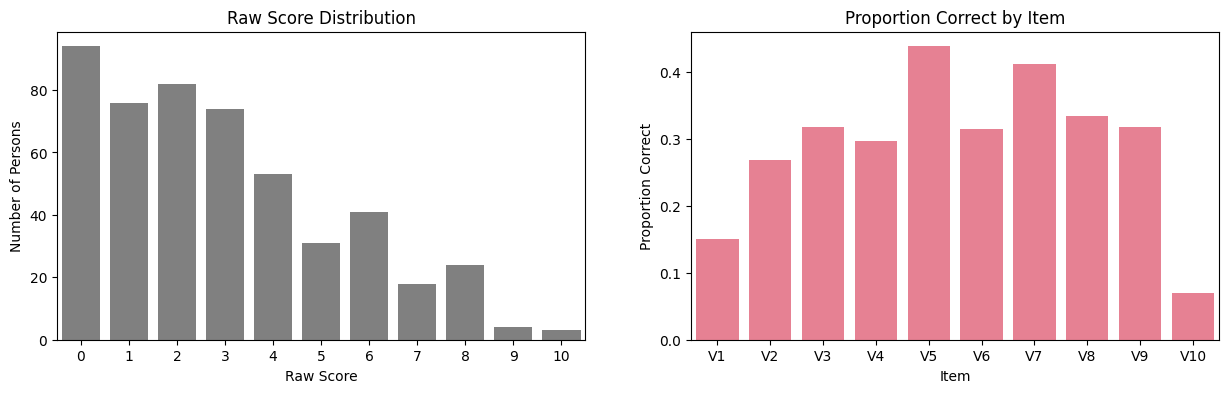

In [8]:
plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl")
f, (ax1, ax2) = plt.subplots(1, 2)

# raw score distribution
raw_score_dist = df.sum(axis='columns').value_counts().sort_index().reset_index()
raw_score_dist.columns = ['Raw Score', 'Number of Persons']
sns.barplot(x='Raw Score', y='Number of Persons', data=raw_score_dist, ax=ax1, color='grey')
ax1.set_title('Raw Score Distribution')
ax1.set_xlabel('Raw Score')
ax1.set_ylabel('Number of Persons')

# performance by item
prop_correct = df.mean()
prop_correct = prop_correct.reset_index()
prop_correct.columns = ['Item', 'Proportion Correct']
sns.barplot(x='Item', y='Proportion Correct', data=prop_correct, ax=ax2)
ax2.set_title('Proportion Correct by Item')
ax2.set_xlabel('Item')
ax2.set_ylabel('Proportion Correct')

plt.show()


# Results

In [9]:
def icc_1pl(theta, b):
    return 1 / (1 + np.exp(-(theta - b)))

def inf_1pl(p_theta):
    return p_theta * (1 - p_theta)


def icc_4pl(theta, a, b, c=0, d=1):
    return c + ((d - c) / (1 + np.exp(-a * (theta - b))))

def inf_4pl(theta, a, b, c=0, d=1):

    p_theta = icc_4pl(theta, a, b, c, d)

    return ((a**2) * ((p_theta - c)**2) * ((d - p_theta)**2)) / (
        ((d - c)**2) * p_theta * (1 - p_theta)
    )

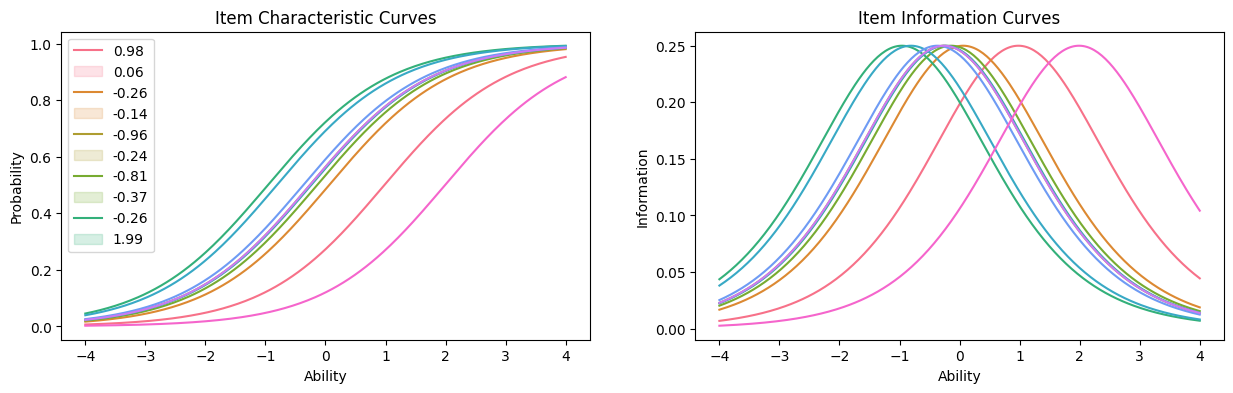

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl", 10)
f, (ax1, ax2) = plt.subplots(1, 2)

theta = np.linspace(-4, 4, 256, endpoint=True)
# beta = [1.26, 0.3, -0.07, 0.1, -0.76, -0.01, -0.6, -0.16, -0.07, 2.33]
beta = [0.98, 0.06, -0.26, -0.14, -0.96, -0.24, -0.81, -0.37, -0.26, 1.99]
for b in beta:
    p_theta = icc_1pl(theta, b)
    sns.lineplot(x=theta, y=p_theta, ax=ax1)
    sns.lineplot(x=theta, y=inf_1pl(p_theta), ax=ax2)

ax1.set_title('Item Characteristic Curves')
ax1.set_xlabel('Ability')
ax1.set_ylabel('Probability')

ax2.set_title('Item Information Curves')
ax2.set_xlabel('Ability')
ax2.set_ylabel('Information')

ax1.legend(beta)

plt.show()


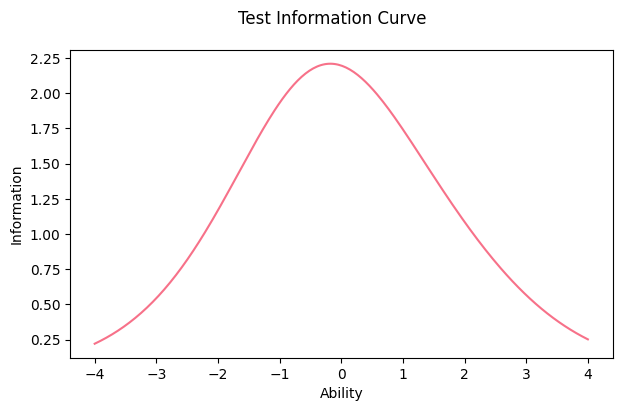

In [11]:
# Test Information Curve

test_inf = []
for b in beta:
    p_theta = icc_1pl(theta, b)
    test_inf.append(inf_1pl(p_theta))

plt.rcParams["figure.figsize"] = (7,4)
plt.plot(theta, np.sum(test_inf, axis=0))

plt.suptitle('Test Information Curve')
plt.xlabel('Ability')
plt.ylabel('Information')

plt.show()

# References

1. https://quantdev.ssri.psu.edu/tutorials/introduction-irt-modeling

2. https://www.youtube.com/watch?v=SrdbllMYq8M&list=PLJNUIJnElUzDmrIPunMyF3tTvIHb65wNb&index=1